# initialization

## parametres

In [1]:
mode= 'bilinear'
width = 32
base_levels = 1.61803
base_levels = 2
n_sublevel = 2
n_azimuth = 18
n_theta = 8
n_phase = 2
do_whitening = False
N_batch = 4
pattern = 'i05june05_static_street_boston_*.jpeg'

## libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import os

In [4]:
import torch
torch.set_default_tensor_type('torch.DoubleTensor')

In [5]:
%load_ext watermark
%watermark -i -h -m -v -p numpy,torch,POLO  -r -g -b

2020-02-17T12:30:22+01:00

CPython 3.7.6
IPython 7.12.0

numpy 1.18.1
torch 1.4.0
POLO not installed

compiler   : Clang 11.0.0 (clang-1100.0.33.16)
system     : Darwin
release    : 19.3.0
machine    : x86_64
processor  : i386
CPU cores  : 36
interpreter: 64bit
host name  : fortytwo
Git hash   : 254ed2149e6bea6c381013db670b8b92e0d1bb8c
Git repo   : https://github.com/bicv/POLO/
Git branch : master


## loading an image

In [6]:
%ls ../data/

800px-Fox_Hunt_1893_Winslow_Homer.jpg
homer.jpg
i05june05_static_street_boston_p1010764.jpeg*
i05june05_static_street_boston_p1010764.npy
i05june05_static_street_boston_p1010785.jpeg*
i05june05_static_street_boston_p1010800.jpeg*
i05june05_static_street_boston_p1010806.jpeg*
i05june05_static_street_boston_p1010808.jpeg*


In [7]:
from SLIP import imread

Tensor shape= torch.Size([1, 1, 768, 1024])


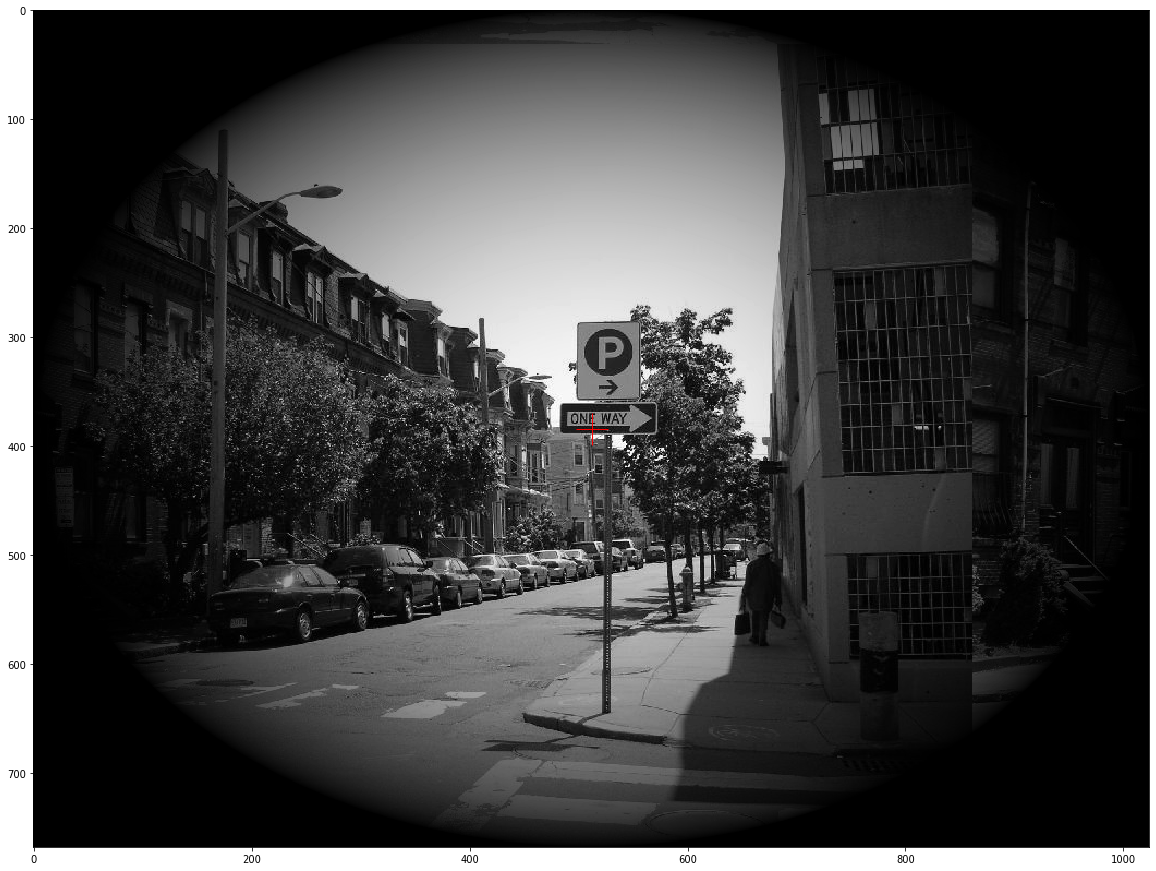

In [8]:
img_orig = imread('../data/i05june05_static_street_boston_p1010764.jpeg')
ds = 1
if ds>1: img_orig = img_orig[::ds, ::ds]
img_orig = np.roll(img_orig, -162//ds, axis=1) # sliding gaze to the right by moving image to the left
img_orig = np.roll(img_orig, 32//ds, axis=0) # sliding gaze to the top by moving image to the bottom
from SLIP import Image
N_X, N_Y = img_orig.shape
pe = {'N_X': N_X, 'N_Y': N_Y, 'do_mask': True, 'do_whitening': True,
       'white_n_learning': 0, 'white_N': 0.07, 'white_N_0': 0.0, 'white_f_0': 0.4, 'white_alpha': 1.4,
      'white_steepness': 4.0}

im = Image(pe)
if do_whitening: img_orig = im.whitening(img_orig)
img_orig *= im.mask
img_tens = torch.Tensor(img_orig[None, None, ...])
print('Tensor shape=', img_tens.shape)

fig, ax = plt.subplots(figsize=(20,20))
if do_whitening: 
    ax.imshow(im.dewhitening(img_orig), cmap='gray')
else:
    ax.imshow(img_orig, cmap='gray')
ax.plot([img_orig.shape[1]/2], [img_orig.shape[0]/2], 'r+', ms=32);

# using torch to build up a Gaussian pyramid

https://pytorch.org/docs/master/nn.functional.html#torch.nn.functional.interpolate

## recursively down-sampling

In [9]:
from torch.nn.functional import interpolate
from torch.nn.functional import max_pool2d

In [10]:
%%timeit
interpolate(img_tens, scale_factor=1/2, mode=mode)

1.04 ms ± 14.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [11]:
from torch.nn.functional import interpolate
img_down = img_tens
n_levels = 0
while max(img_down.shape[-2:]) > width :
    n_levels += 1
    print('Tensor shape=', img_down.shape, ', n_levels=', n_levels)
    print(np.log(img_down.shape[-2:])/np.log(base_levels)-np.log(width)/np.log(base_levels))
    img_down = interpolate(img_down, scale_factor=1/base_levels, mode=mode)
n_levels += 1
print('Top tensor shape=', img_down.shape, ', Final n_levels=', n_levels)

Tensor shape= torch.Size([1, 1, 768, 1024]) , n_levels= 1
[4.5849625 5.       ]
Tensor shape= torch.Size([1, 1, 384, 512]) , n_levels= 2
[3.5849625 4.       ]
Tensor shape= torch.Size([1, 1, 192, 256]) , n_levels= 3
[2.5849625 3.       ]
Tensor shape= torch.Size([1, 1, 96, 128]) , n_levels= 4
[1.5849625 2.       ]
Tensor shape= torch.Size([1, 1, 48, 64]) , n_levels= 5
[0.5849625 1.       ]
Top tensor shape= torch.Size([1, 1, 24, 32]) , Final n_levels= 6


In [12]:
n_levels = int(np.log(np.max(img_orig.shape)/width)/np.log(base_levels)) + 1
print('Computed n_levels=', n_levels)

Computed n_levels= 6


Applying on the central crop of $32\times32$:

In [13]:
def cropped_pyramid(img_tens, width=width, base_levels=base_levels, verbose=False):
    
    N_batch, _, N_X, N_Y = img_tens.shape
    n_levels = int(np.log(np.max((N_X, N_Y))/width)/np.log(base_levels)) + 1
    
    img_crop = torch.zeros((N_batch, n_levels, width, width))

    img_down = img_tens
    for i_level in range(n_levels-1):
        if verbose: print('Tensor shape=', img_down.shape, ', shape=', img_tens.shape)
        h_res, w_res = img_down.shape[-2:]

        img_crop[:, i_level, :, :] = img_down[:, 0, 
                            (h_res//2-width//2):(h_res//2+width//2), 
                            (w_res//2-width//2):(w_res//2+width//2)]
        img_down = interpolate(img_down, scale_factor=1/base_levels, mode=mode)

    h_res, w_res = img_down.shape[-2:]
    img_crop[:, n_levels-1, 
             (width//2-h_res//2):(width//2+h_res//2), 
             (width//2-w_res//2):(width//2+w_res//2)] = img_down[:, 0, :, :]
    if verbose: print('Top tensor shape=', img_down.shape, ', Final n_levels=', n_levels)
    return img_crop

Tensor shape= torch.Size([1, 1, 768, 1024]) , shape= torch.Size([1, 1, 768, 1024])
Tensor shape= torch.Size([1, 1, 384, 512]) , shape= torch.Size([1, 1, 768, 1024])
Tensor shape= torch.Size([1, 1, 192, 256]) , shape= torch.Size([1, 1, 768, 1024])
Tensor shape= torch.Size([1, 1, 96, 128]) , shape= torch.Size([1, 1, 768, 1024])
Tensor shape= torch.Size([1, 1, 48, 64]) , shape= torch.Size([1, 1, 768, 1024])
Top tensor shape= torch.Size([1, 1, 24, 32]) , Final n_levels= 6
Tensor shape= torch.Size([1, 6, 32, 32])


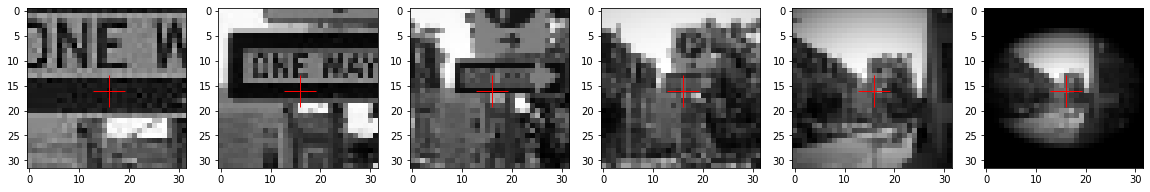

In [14]:
img_tens = torch.Tensor(img_orig[None, None, ...])
img_crop = cropped_pyramid(img_tens, verbose=True)

fig, axs = plt.subplots(1, n_levels, figsize=(20,20))
for i_level, ax in enumerate(axs):
    ax.imshow(img_crop.numpy()[0, i_level, ...], cmap='gray')
    ax.plot([width/2], [width/2], 'r+', ms=32);
print('Tensor shape=', img_crop.shape)

## creating a set of filters

In [15]:
from LogGabor import LogGabor
pe = {'N_X': width, 'N_Y': width, 'do_mask': False, 'do_whitening': True,
      'white_name_database': 'kodakdb', 'white_n_learning': 0, 'white_N':
          0.07, 'white_N_0': 0.0, 'white_f_0': 0.4, 'white_alpha': 1.4,
      'white_steepness': 4.0, 'white_recompute': False, 'base_levels':
          base_levels, 'n_theta': 24, 'B_sf': 0.6, 'B_theta': np.pi/12 ,
      'use_cache': True, 'figpath': 'results', 'edgefigpath':
          'results/edges', 'matpath': 'cache_dir', 'edgematpath':
          'cache_dir/edges', 'datapath': 'database/', 'ext': '.pdf', 'figsize':
          14.0, 'formats': ['pdf', 'png', 'jpg'], 'dpi': 450, 'verbose': 0}
lg = LogGabor(pe)
print('lg shape=', lg.pe.N_X, lg.pe.N_Y)

lg shape= 32 32


In [16]:
def local_filter(azimuth, theta, phase, sf_0=.25, radius=width/4):

    x, y = lg.pe.N_X//2, lg.pe.N_Y//2 # center
    x += radius * np.cos(azimuth)
    y += radius * np.sin(azimuth)
    
    return lg.normalize(lg.invert(
        lg.loggabor(x, y, sf_0=sf_0, B_sf=lg.pe.B_sf, theta=theta, B_theta=lg.pe.B_theta) * np.exp(-1j * phase)))

K = local_filter(azimuth=0, theta=0, phase=0, radius=width/4)
print('K shape=', K.shape)
print('K min max=', K.min(), K.max())

K shape= (32, 32)
K min max= -0.4102999708906189 1.0


In [17]:
def get_K(width=width, n_sublevel = n_sublevel, n_azimuth = n_azimuth, n_theta = n_theta, n_phase = n_phase, verbose=False):
    K = np.zeros((width, width, n_sublevel, n_azimuth, n_theta, n_phase))
    for i_sublevel in range(n_sublevel):
        sf_0 = .25*(np.sqrt(2)**i_sublevel)
        radius = width/4/(np.sqrt(2)**i_sublevel)
        if verbose: print('i_sublevel, sf_0, radius', i_sublevel, sf_0, radius)
        for i_azimuth in range(n_azimuth):
            for i_theta in range(n_theta):
                for i_phase in range(n_phase):
                    K[..., i_sublevel, i_azimuth, i_theta, i_phase] = local_filter(azimuth=(i_azimuth+i_sublevel/2)*2*np.pi/n_azimuth, 
                                                                                   theta=i_theta*np.pi/n_theta, 
                                                                                   phase=i_phase*np.pi/n_phase, sf_0=sf_0, radius=radius)
    K = torch.Tensor(K)

    if verbose: print('K shape=', K.shape)
    if verbose: print('K min max=', K.min(), K.max())

    return K
K = get_K(verbose=True)

i_sublevel, sf_0, radius 0 0.25 8.0
i_sublevel, sf_0, radius 1 0.3535533905932738 5.65685424949238
K shape= torch.Size([32, 32, 2, 18, 8, 2])
K min max= tensor(-1.) tensor(1.)


## applying the filter

In [18]:
print('Tensor shape=', img_crop.shape)

Tensor shape= torch.Size([1, 6, 32, 32])


In [19]:
%%timeit
out = torch.tensordot(img_crop, K,  dims=2)

52.2 µs ± 1.66 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [20]:
out = torch.tensordot(img_crop, K,  dims=2)
print('Tensor shape=', out.shape)

Tensor shape= torch.Size([1, 6, 2, 18, 8, 2])


# reconstruction

## layer by layer from cropped central images

Tensor shape= torch.Size([1, 6, 32, 32])


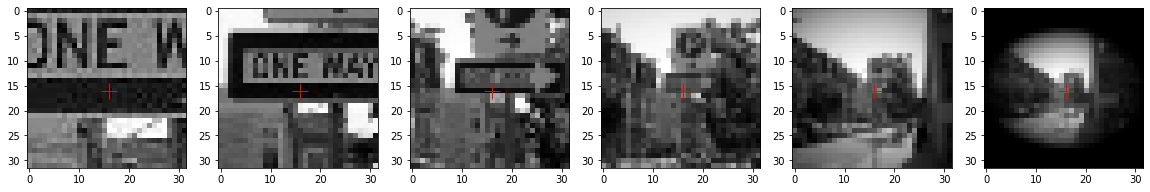

In [21]:
fig, axs = plt.subplots(1, n_levels, figsize=(20,20))
for i_level, ax in enumerate(axs):
    ax.imshow(img_crop.numpy()[0, i_level, ...], cmap='gray')
    ax.plot([width/2], [width/2], 'r+', ms=16);
print('Tensor shape=', img_crop.shape)

In [22]:
print('Tensor shape=', K.shape)
K_ = K.reshape((width**2, n_sublevel*n_azimuth*n_theta*n_phase))
print('Tensor shape=', K_.shape)

Tensor shape= torch.Size([32, 32, 2, 18, 8, 2])
Tensor shape= torch.Size([1024, 576])


In [23]:
print('Tensor shape=', out.shape)
out__ = out.reshape((1, n_levels, n_sublevel*n_azimuth*n_theta*n_phase))
print('Tensor shape=', out__.shape)

Tensor shape= torch.Size([1, 6, 2, 18, 8, 2])
Tensor shape= torch.Size([1, 6, 576])


In [24]:
img_rec =  torch.tensordot(out__, K_.T,  dims=1).reshape((1, n_levels, width, width))
print('Tensor shape=', img_rec.shape)

Tensor shape= torch.Size([1, 6, 32, 32])


Tensor shape= torch.Size([1, 6, 32, 32])


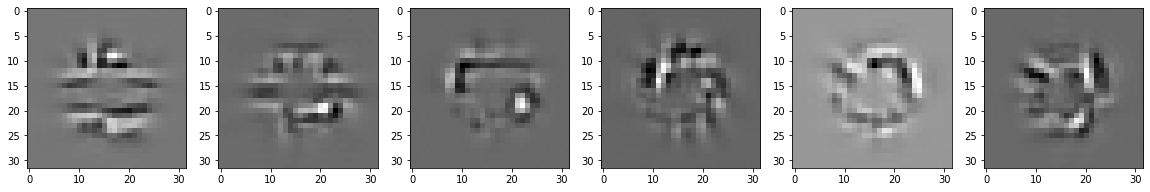

In [25]:
fig, axs = plt.subplots(1, n_levels, figsize=(20,20))
for i_level, ax in enumerate(axs):
    ax.imshow(img_rec.numpy()[0, i_level, ...], cmap='gray')
print('Tensor shape=', img_crop.shape)

## inverse pyramid from the coefficients

In [26]:
def inverse_pyramid(out, K, N_X=N_X, N_Y=N_Y, base_levels=base_levels, damp=1, verbose=False):
    N_batch = out.shape[0]
    width =  K.shape[0]
    n_levels = int(np.log(np.max((N_X, N_Y))/width)/np.log(base_levels)) + 1
    n_sublevel, n_azimuth, n_theta, n_phase = K.shape[2:]
    
    out__ = out.reshape((N_batch, n_levels, n_sublevel*n_azimuth*n_theta*n_phase))
    K_ = K.reshape((width**2, n_sublevel*n_azimuth*n_theta*n_phase))
    img_crop_rec =  torch.tensordot(out__, K_.T,  dims=1).reshape((N_batch, n_levels, width, width))

    img_rec = img_crop_rec[:, -1, :, :].unsqueeze(1)
    for i_level in range(n_levels-1)[::-1]: # from the top to the bottom of the pyramid
        img_rec = interpolate(img_rec, scale_factor=base_levels, mode=mode) / damp
        h_res, w_res = img_rec.shape[-2:]
        img_rec[:, 0, (h_res//2-width//2):(h_res//2+width//2), (w_res//2-width//2):(w_res//2+width//2)] += img_crop_rec[:, i_level, :, :]
    img_rec = img_rec[:, :, (h_res//2-N_X//2):(h_res//2+N_X//2), (w_res//2-N_Y//2):(w_res//2+N_Y//2)]

    return img_rec

img_rec = inverse_pyramid(out, K)

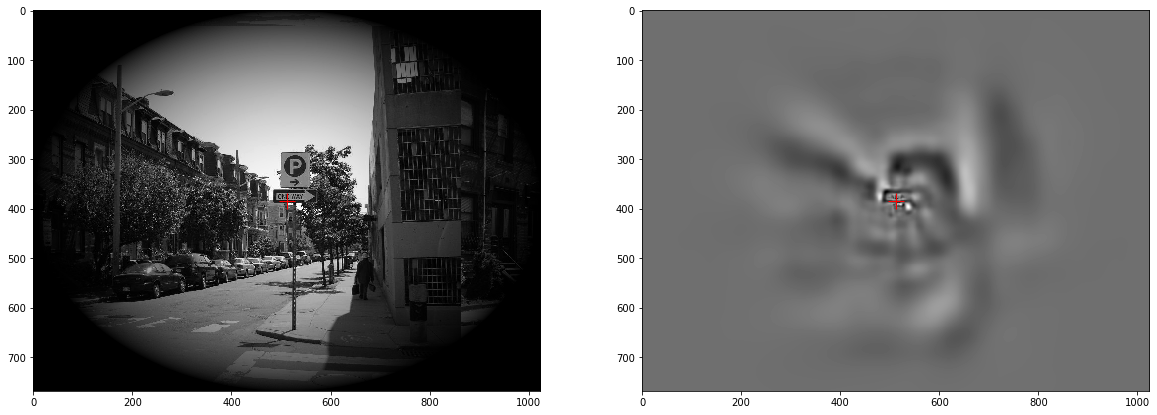

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(20,20))
for ax, img in zip(axs, [img_tens, img_rec.detach()]):
    if do_whitening: 
        ax.imshow(im.dewhitening(img[0, 0, :, :].numpy()), cmap='gray')
    else:
        ax.imshow(img[0, 0, :, :].numpy(), cmap='gray')
    ax.plot([N_Y//2], [N_X//2], 'r+', ms=16);

# optimizing the reconstruction

## defining a dataloader

In [28]:
def get_dataloader(K, N_batch, pattern=pattern, 
                   ds=ds, saccade_radius=.4, verbose=False):
    from glob import glob
    imgs = []
    for fname in glob(os.path.join('../data', pattern)):
        img_orig = imread(fname)
        if ds>1: img_orig = img_orig[::ds, ::ds]
        from SLIP import Image
        pe = {'N_X': img_orig.shape[0], 'N_Y': img_orig.shape[1], 'do_mask': True, 'do_whitening': True,
               'white_n_learning': 0, 'white_N': 0.07, 'white_N_0': 0.0, 'white_f_0': 0.4, 'white_alpha': 1.4,
              'white_steepness': 4.0}
        im = Image(pe)
        if do_whitening: img_orig = im.whitening(img_orig)
        imgs.append(img_orig)
                          
    N_imgs = len(imgs)
    if verbose: print('N_imgs ', N_imgs )
    N_X, N_Y = img_orig.shape
    width = K.shape[0]
    #n_levels = int(np.log(np.max((N_X, N_Y))/width)/np.log(base_levels)) + 1

    target = torch.zeros((N_batch, 1, N_X, N_Y))
    for i in range(N_batch):
        # generate random saccades
        target_ = imgs[int(N_imgs*np.random.rand())].copy()
        sacc_x, sacc_y = np.int(saccade_radius*N_X*np.random.randn()), np.int(saccade_radius*N_Y*np.random.randn())
        if verbose: print('sacc_x, sacc_y ', sacc_x, sacc_y )
        target_ = np.roll(target_, sacc_y, axis=1)
        target_ = np.roll(target_, sacc_x, axis=0) 
        target_ *= im.mask
        target[i, :, :, :] = torch.from_numpy(target_[None, :, :])

    if verbose: print(target.shape)
    img_crop = cropped_pyramid(target, verbose=verbose)
    if verbose: print(img_crop.shape)
    out = torch.tensordot(img_crop, K, dims=2)

    from torch.utils.data import TensorDataset, DataLoader
    dataloader = DataLoader(TensorDataset(target, out), batch_size=N_batch, shuffle=False, drop_last=False)
    return dataloader

dataloader = get_dataloader(K, N_batch, verbose=True)

N_imgs  5
sacc_x, sacc_y  -443 363
sacc_x, sacc_y  -403 877
sacc_x, sacc_y  -53 21
sacc_x, sacc_y  35 219
torch.Size([4, 1, 768, 1024])
Tensor shape= torch.Size([4, 1, 768, 1024]) , shape= torch.Size([4, 1, 768, 1024])
Tensor shape= torch.Size([4, 1, 384, 512]) , shape= torch.Size([4, 1, 768, 1024])
Tensor shape= torch.Size([4, 1, 192, 256]) , shape= torch.Size([4, 1, 768, 1024])
Tensor shape= torch.Size([4, 1, 96, 128]) , shape= torch.Size([4, 1, 768, 1024])
Tensor shape= torch.Size([4, 1, 48, 64]) , shape= torch.Size([4, 1, 768, 1024])
Top tensor shape= torch.Size([4, 1, 24, 32]) , Final n_levels= 6
torch.Size([4, 6, 32, 32])


## validating on the test set

In [29]:
test_dataloader = get_dataloader(K, N_batch, verbose=False)
for batch_idx, (target, out) in enumerate(test_dataloader):
    print(batch_idx, target.shape, out.shape)

0 torch.Size([4, 1, 768, 1024]) torch.Size([4, 6, 2, 18, 8, 2])


In [30]:
img_rec = inverse_pyramid(out, K, damp=2)
print('img_rec.shape', img_rec.shape)

img_rec.shape torch.Size([4, 1, 768, 1024])


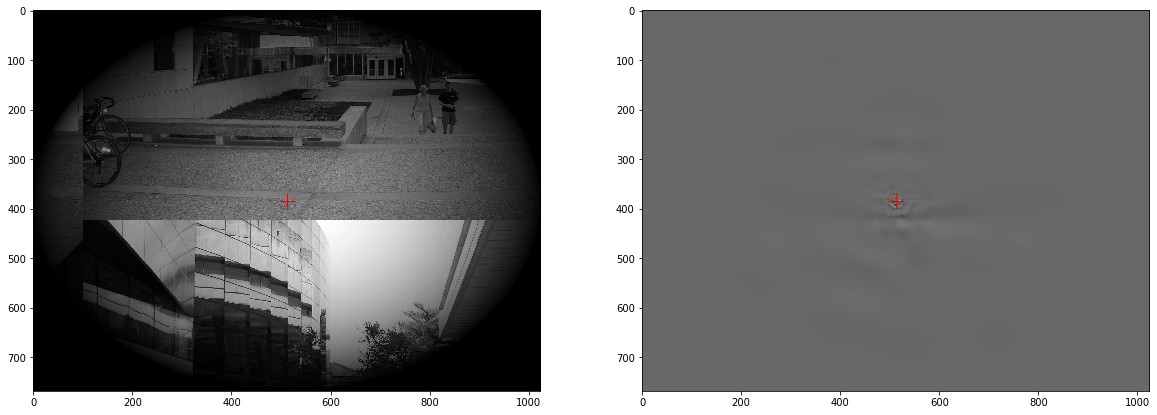

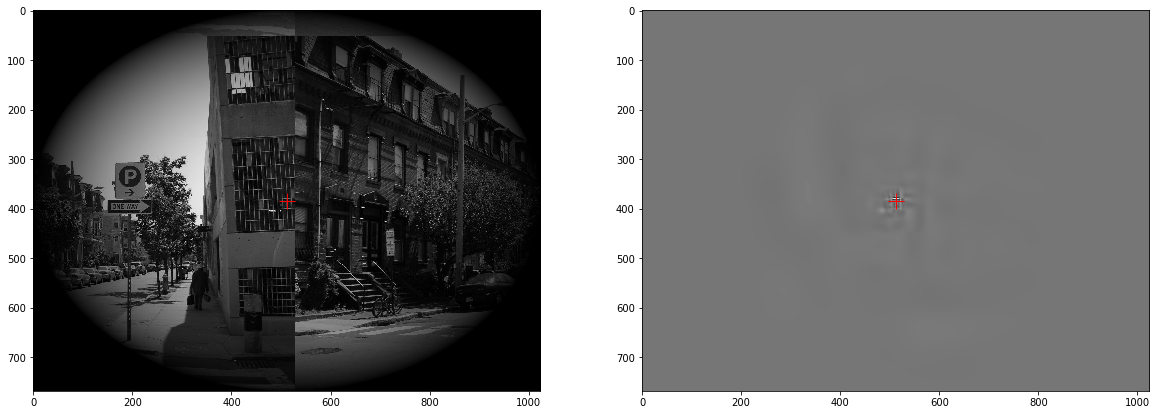

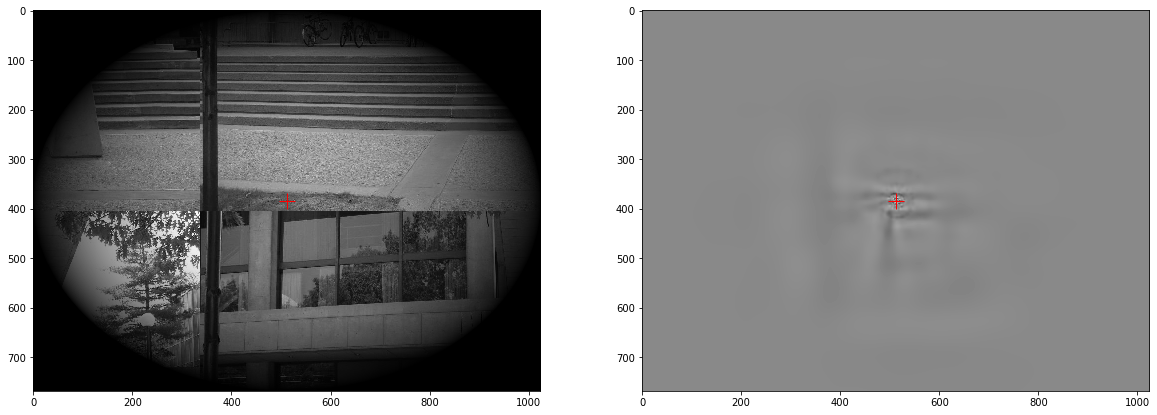

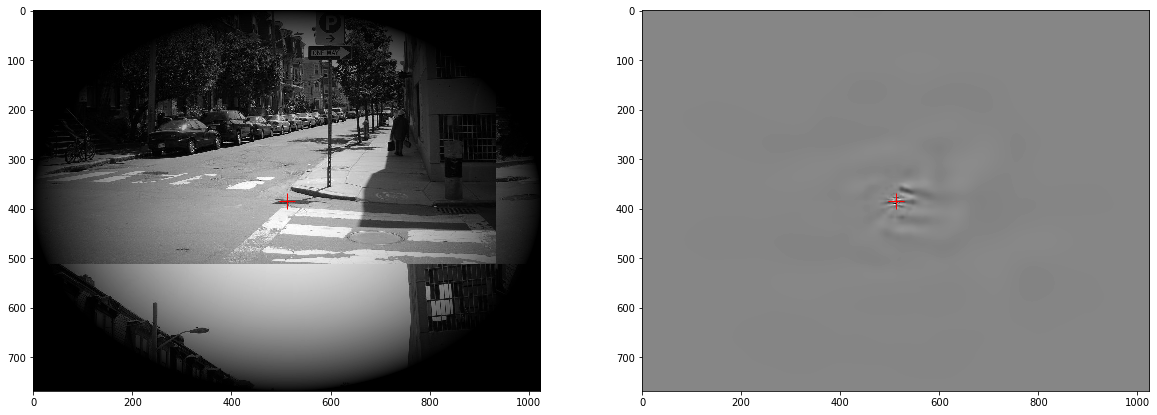

In [31]:
for i_batch in range(N_batch):
    fig, axs = plt.subplots(1, 2, figsize=(20, 20))
    for ax, img in zip(axs, [target[i_batch, 0, :, :], img_rec[i_batch, 0, :, :]]):
        if do_whitening: 
            ax.imshow(im.dewhitening(img.numpy()), cmap='gray')
        else:
            ax.imshow(img.numpy(), cmap='gray')
        ax.plot([N_Y//2], [N_X//2], 'r+', ms=16);


## testing different parameters

In [32]:
K = get_K(n_azimuth = 9)

In [33]:
test_dataloader = get_dataloader(K, N_batch, verbose=False)
for batch_idx, (target, out) in enumerate(test_dataloader):
    print(batch_idx, target.shape, out.shape)

0 torch.Size([4, 1, 768, 1024]) torch.Size([4, 6, 2, 9, 8, 2])


In [34]:
img_rec = inverse_pyramid(out, K)
print('img_rec.shape', img_rec.shape)

img_rec.shape torch.Size([4, 1, 768, 1024])


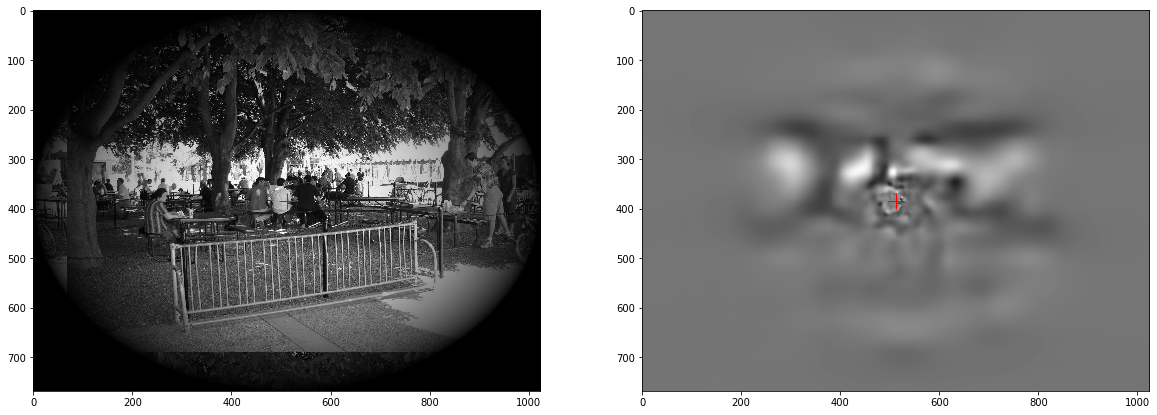

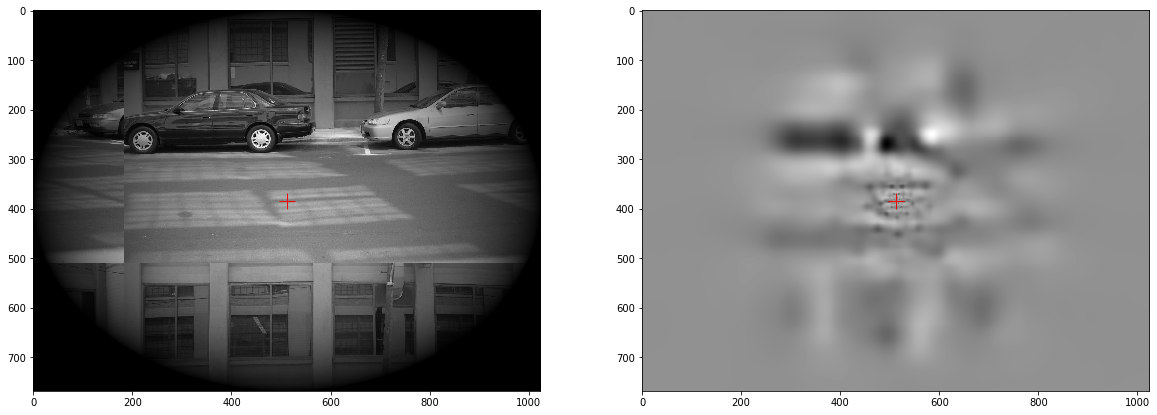

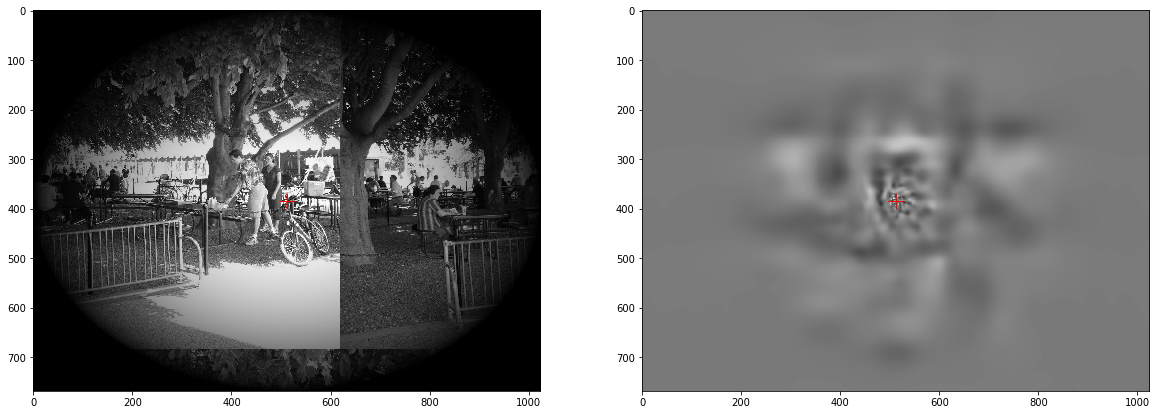

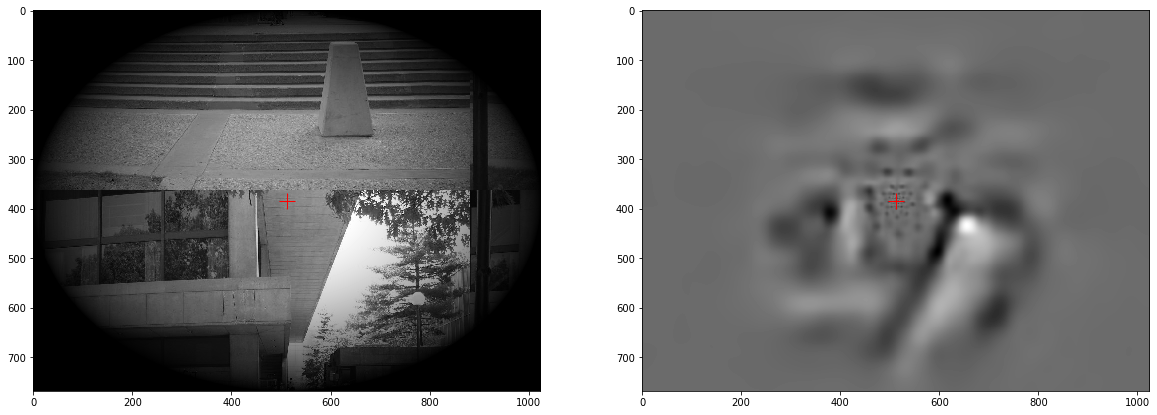

In [35]:
for i_batch in range(N_batch):
    fig, axs = plt.subplots(1, 2, figsize=(20, 20))
    for ax, img in zip(axs, [target[i_batch, 0, :, :], img_rec[i_batch, 0, :, :]]):
        if do_whitening: 
            ax.imshow(im.dewhitening(img.numpy()), cmap='gray')
        else:
            ax.imshow(img.numpy(), cmap='gray')
        ax.plot([N_Y//2], [N_X//2], 'r+', ms=16);


## estimating running time in realistic conditions (no downscaling, ds=1)

In [36]:
%%timeit
K = get_K()

145 ms ± 1.84 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [37]:
N_batch = 128
K = get_K()
test_dataloader = get_dataloader(K, N_batch, ds=1, verbose=False)
for batch_idx, (target, out) in enumerate(test_dataloader):
    print(batch_idx, target.shape, out.shape)
    N_X, N_Y = target.shape[-2:]
    img_crop = cropped_pyramid(target)
    out = torch.tensordot(img_crop, K,  dims=2)
    img_rec = inverse_pyramid(out, K, N_X, N_Y)

0 torch.Size([128, 1, 768, 1024]) torch.Size([128, 6, 2, 18, 8, 2])


In [38]:
%%timeit
img_crop = cropped_pyramid(target)

389 ms ± 4.15 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [39]:
%%timeit
out = torch.tensordot(img_crop, K,  dims=2)

2.41 ms ± 127 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [40]:
out = torch.tensordot(img_crop, K,  dims=2)

In [41]:
%%timeit
img_rec = inverse_pyramid(out, K, N_X, N_Y)

2.43 s ± 61.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
